# Error Mitigation

In [1]:
# %load_ext autoreload
# %autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

## Small Systems of NV center and Surface Electron Spin 

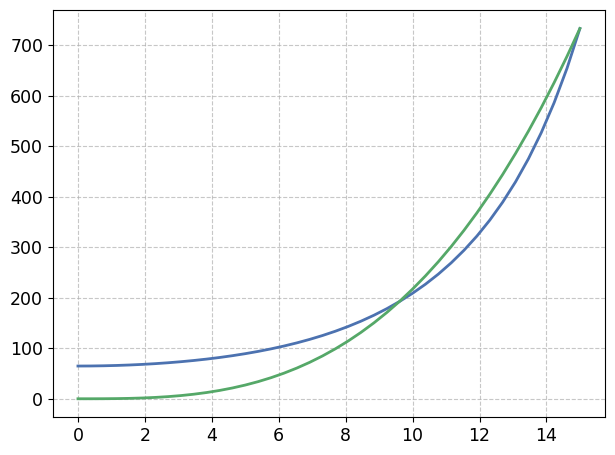

In [46]:
rz = 15e-9
rx = np.linspace(0, 15e-9, 40)
prefactor = -(c.hbar * c.mu_0) / (4 * np.pi) * CONST['gamma_e']**2

fig, ax = plt.subplots()
ax.plot(rx*1e9, abs(4*np.pi/prefactor *1e6 * (rx**2+rz**2)**(5/2)/(2*rz**2-rx**2) ))
ax.plot(rx*1e9, abs(4*np.pi/prefactor *1e6 * 2**(5/2)*rx**3) )

In [465]:
prefactor = (c.hbar * c.mu_0) / (4 * np.pi) * CONST['gamma_e']**2 / (2*np.pi)
period_fraction = 2

radius = 12e-9
t = 1/4 * abs(prefactor) * 1/radius**3 # element in the Hamiltonian 
period = 1/(2*t)
time = period/period_fraction *1e6
a = 8*np.pi**2/(c.hbar*c.mu_0*CONST['gamma_e']**2) *1e-27 *1e6
1/a

52.05976760578134

[[-60254.36065484      0.              0.        ]
 [     0.          30127.18032742     -0.        ]
 [     0.             -0.          30127.18032742]]


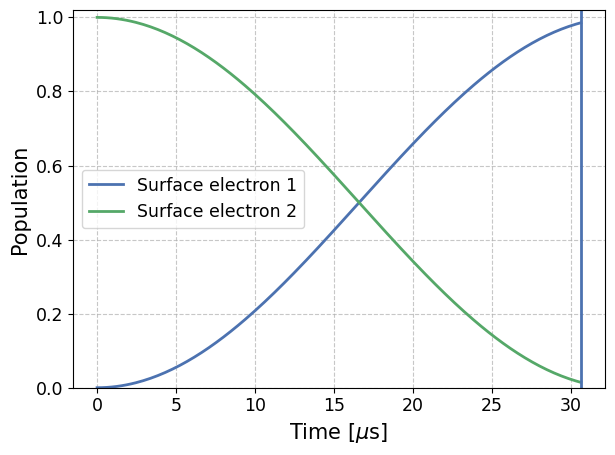

In [452]:
# surface spin flip flop interaction
radius = 12e-9
register_config = [('e', (0,0, 1e-08), 1, dict(Bz=300e-4)), ('e', (radius,0, 1e-08), 0, dict(Bz=300e-4))]
kwargs = dict(suter_method=False, verbose=False, env_approx_level = 'no_bath')
env = Environment2(register_config, **kwargs)

env.gate_props_list = [('free_evo', dict(t=0.e-6))]

t_end = calc_interaction_sphere(radius=radius)
t_list = np.linspace(0, t_end, 200)
states = env.calc_states(t_list)[0,:]

e1_dms = [dm.ptrace(0) for dm in states]
e2_dms = [dm.ptrace(1) for dm in states]

fig, ax = plt.subplots()
ax.plot(t_list*1e6, [dm[0,0].real for dm in e1_dms], label='Surface electron 1')
ax.plot(t_list*1e6, [dm[0,0].real for dm in e2_dms], label='Surface electron 2')
ax.set_ylim(0,1.02)
ax.set_ylabel(r'Population')
ax.set_xlabel(r'Time [$\mu$s]')
ax.legend()

ax.axvline(x=t_end *1e6)
plt.show()

## Create Spin Baths

In [62]:
# create, save and load a spinbath
num_baths, num_init_states, all_init_states = 1000, 1, False
directory = os.getcwd()
filename = os.path.join( "baths", "test18_full_fix")
kwargs = dict(
    density = 5e-3 / 1e-18, # spins/nm^2 # 1e-3 - 50e-3
    shape = 'circle',
    rmin = 0, 
    rmax = 18e-9,
    bath_kwargs = dict(Bz=500e-4, depth=10e-9),
)

spin_bath = SpinBath('e', **kwargs)
bath_configs, metadata = spin_bath.calc_spin_baths(num_baths, num_init_states, all_init_states=all_init_states)

print("Number of bath spins: ", spin_bath.num_spins)
bath_polarization = calc_bath_polarization(bath_configs)
print("Bath Polarization: ", bath_polarization)

save_spin_baths(bath_configs, metadata, directory, filename)
bath_configs = load_spin_baths(filename, directory)
#fig, ax = visualize_spin_bath(bath_configs, metadata)

Number of bath spins:  5
Bath Polarization:  0.5


In [ ]:
save_spin_baths(bath_configs, metadata, directory, filename)

In [63]:
fix_spin = ['e', (0,0,0), 0, kwargs['bath_kwargs']]
bath_configs_fix = []
for bath_config in bath_configs:
    bath_config.extend([fix_spin])
    bath_configs_fix.append(bath_config)
bath_configs_fix

[[['e',
   [-8.113641195573888e-09, -1.0582268273954289e-08, 1e-08],
   0,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e',
   [-1.4066850525457615e-08, 5.817651673922798e-09, 1e-08],
   1,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e',
   [1.0866341109802642e-08, -8.787375303958837e-09, 1e-08],
   1,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e',
   [1.2942114012341033e-08, -3.007297155679911e-09, 1e-08],
   0,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e',
   [-8.711995783416487e-09, 7.833599712490962e-09, 1e-08],
   1,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e', (0, 0, 0), 0, {'Bz': 0.05, 'depth': 1e-08}]],
 [['e',
   [9.721811026372341e-09, 6.371932194486937e-09, 1e-08],
   0,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e',
   [5.95600235885297e-09, 1.4068090551904941e-08, 1e-08],
   1,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e',
   [-1.0876305670562574e-10, 1.5883336650651244e-10, 1e-08],
   1,
   {'Bz': 0.05, 'depth': 1e-08}],
  ['e',
   [-7.88725217727843e-09, 5.978880047695618e-09, 1e-08],
   0,
   {'Bz': 0.0

Bath Polarization:  0.04


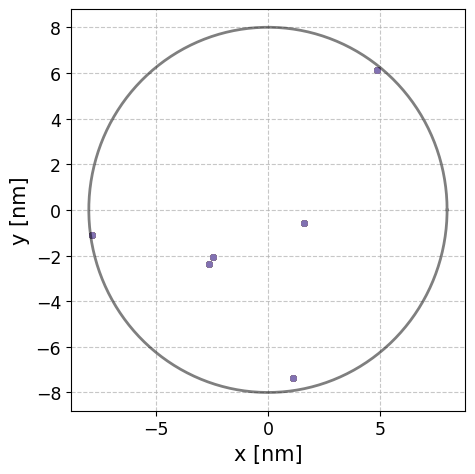

In [11]:
# cut an existing spin bath
rmin, rmax = 0, 8e-9
cutoff = np.sqrt( (10e-9)**2 + (rmax)**2)

directory = os.getcwd()
filename = os.path.join( "baths", "test_14")

bath_configs_filtered = cut_spin_bath(bath_configs, cutoff)
metadata = {'rmin': rmin, 'rmax': rmax}

bath_polarization = calc_bath_polarization(bath_configs_filtered)
print("Bath Polarization: ", bath_polarization)

save_spin_baths(bath_configs_filtered, metadata, directory, filename)
bath_configs = load_spin_baths(filename, directory)
fig, ax = visualize_spin_bath(bath_configs_filtered, metadata)

## Ramsey (takes long)

In [8]:
# Pauli expectation values
# %%time
directory = os.path.join(os.getcwd(), "baths")
filename = "test1_full"
bath_configs = load_spin_baths(filename, directory)

import time
t0 = time.time()

for Bz in [20e-9]:
    for env_approx_level in ['gCCE2']:
        register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
        kwargs = dict(dm_offset=1e-5, verbose=True, env_approx_level=env_approx_level, bath_configs=bath_configs, suter_method=False, thermal_bath=True, parallelization=True)
        env = Environment2(register_config, **kwargs)
        
        t_end, t_steps = 50e-6, 500
        t_list = np.linspace(0, t_end, t_steps)
        miri_list = calc_miri_list(env, t_end, t_steps, pauli=True) # pauli=False for populations
        
        # saving
        save_directory = os.path.join(os.getcwd(), "export", filename)
        os.makedirs(save_directory, exist_ok=True)
        save_filename = f"{env.env_approx_level}_{int(Bz*1e9)}nT_Pauli"
        save_loc = os.path.join(save_directory, save_filename)
        np.save(save_loc, miri_list)
        print("Time: ", time.time()-t0)
        print(f'Saved as {save_loc}.npy')

Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:21<00:00,  1.10s/it]


Time:  1115.2242090702057
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\test1_full\gCCE2_20nT_Pauli.npy


In [11]:
# populations
# %%time
directory = os.path.join(os.getcwd(), "baths")
filename = "bench_full15"
bath_configs = load_spin_baths(filename, directory)

import time
t0 = time.time()

for Bz in [0, 20e-9]:
    for env_approx_level in ['no_bath', 'full_bath']:#, 'gCCE0', 'gCCE1', 'gCCE2', 'full_bath']:
        register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
        kwargs = dict(dm_offset=1e-5, verbose=True, env_approx_level=env_approx_level, bath_configs=bath_configs, suter_method=False, thermal_bath=True, parallelization=True)
        env = Environment2(register_config, **kwargs)
        
        t_end, t_steps = 50e-6, 500
        t_list = np.linspace(0, t_end, t_steps)
        miri_list = calc_miri_list(env, t_end, t_steps, pauli=False, old_register_states=[q.fock_dm(2,0)]) # pauli=False for populations
        
        # saving
        save_directory = os.path.join(os.getcwd(), "export", filename)
        os.makedirs(save_directory, exist_ok=True)
        save_filename = f"{env.env_approx_level}_{int(Bz*1e9)}nT"
        save_loc = os.path.join(save_directory, save_filename)
        np.save(save_loc, miri_list)
        print("Time: ", time.time()-t0)
        print(f'Saved as {save_loc}.npy')

State check done.
Time:  0.17402434349060059
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\bench_full15\no_bath_0nT.npy


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.93it/s]


Time:  29.2958083152771
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\bench_full15\full_bath_0nT.npy
State check done.
Time:  29.480019092559814
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\bench_full15\no_bath_20nT.npy


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.52it/s]


Time:  55.507434368133545
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\bench_full15\full_bath_20nT.npy


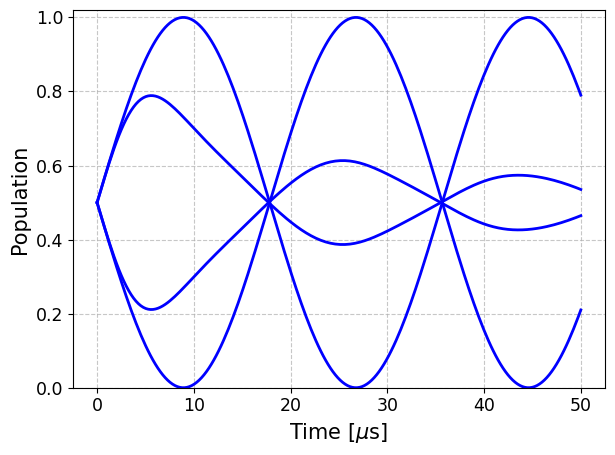

In [488]:
fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "bench_full15")
save_filename = os.path.join('full_bath_1uT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0][0], color='b')
ax.plot(t_list * 1e6, miri_list[1][0], color='b')

save_filename = os.path.join('no_bath_1uT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

ax.plot(t_list * 1e6, miri_list[0][0], color='b')
ax.plot(t_list * 1e6, miri_list[1][0], color='b')


ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.set_ylim(0,1.02)
plt.show()

## Plots

In [16]:
register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=0, N_zz=0, can_flip=False))]
kwargs = dict(dm_offset=1e-5, verbose=True, env_approx_level='gCCE0', bath_configs=bath_configs[15:16], suter_method=False, thermal_bath=True, parallelization=True)
env = Environment2(register_config, **kwargs)

t_end, t_steps = 200e-6, 200
t_list = np.linspace(0, t_end, t_steps)
miri_list = calc_miri_list(env, t_end, t_steps, pauli=False, old_register_states=[q.fock_dm(2,0)]) # pauli=False for populations

fig, ax = plt.subplots()

idx=0
ax.plot(t_list * 1e6, miri_list[0][idx], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, miri_list[1][idx], label=r'$P(m_s=-1)$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()

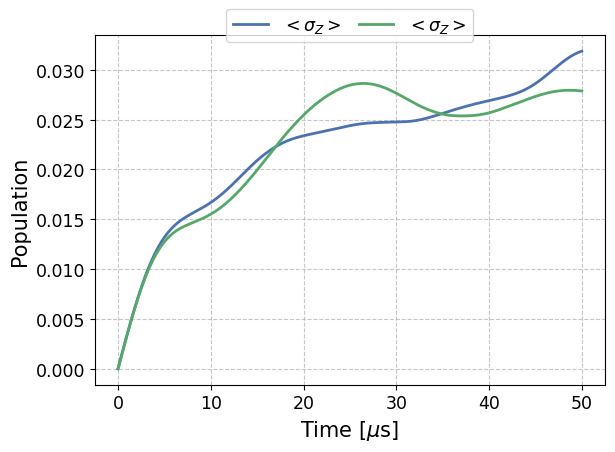

In [11]:
fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "bench_full15")
save_filename = os.path.join('full_bath_20nT_Pauli')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
t_end, t_steps = 50e-6, 500
t_list = np.linspace(0, t_end, t_steps)
# ax.plot(t_list * 1e6, miri_list[idx, 0], label=r'$<\sigma_X>$')
# ax.plot(t_list * 1e6, miri_list[idx, 1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx, 2], label=r'$<\sigma_Z>$')

save_directory = os.path.join(os.getcwd(), "export", "test1_full")
save_filename = os.path.join('full_bath_20nT_Pauli')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx = 4
t_end, t_steps = 50e-6, 500
t_list = np.linspace(0, t_end, t_steps)
# ax.plot(t_list * 1e6, miri_list[idx, 0], label=r'$<\sigma_X>$')
# ax.plot(t_list * 1e6, miri_list[idx, 1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx, 2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')  
plt.show()

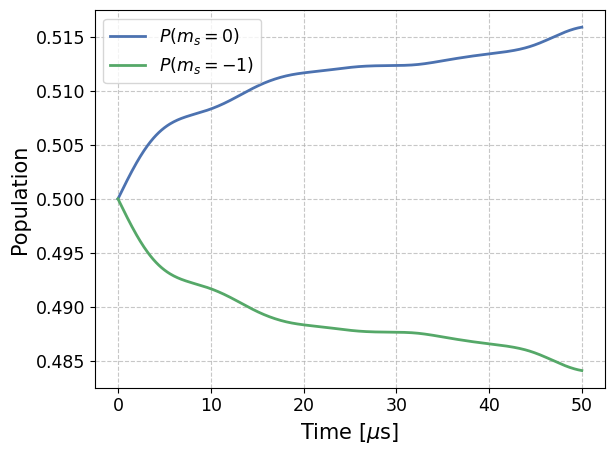

In [5]:
fig, ax = plt.subplots()

save_directory = os.path.join(os.getcwd(), "export", "bench_full15")
save_filename = os.path.join('full_bath_20nT')
save_loc = os.path.join(save_directory, save_filename)
miri_list = np.load(save_loc + ".npy")

idx=0
t_end, t_steps = 50e-6, 500
t_list = np.linspace(0, t_end, t_steps)
ax.plot(t_list * 1e6, miri_list[idx, 0], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, miri_list[idx, 1], label=r'$P(m_s=-1)$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()